In [2]:
from matplotlib import pyplot
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn
import numpy as np
import pandas as pd
import json
import spacy
from collections import Counter
from IPython.display import display, HTML
import warnings
import nltk
from imblearn.over_sampling import RandomOverSampler, SMOTE
from IPython.display import display, HTML
from keras.layers import Input, Embedding, LSTM, Dense, Activation, SpatialDropout1D, Flatten, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential
from keras.preprocessing import text
from keras.utils import np_utils, to_categorical
from keras.preprocessing import sequence
from keras.initializers import Constant
import model_evaluation_utils as meu
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
nlp = spacy.load('en_core_web_lg')

## Settings

In [5]:
warnings.filterwarnings('ignore')
CSS = """

#notebook-container {
    width: 1200px;
}

.CodeMirror-line {
    font-size: 14px !important;
}

.output {
    flex-direction: row;
    flex-wrap: wrap;
}

"""

HTML('<style>{}</style>'.format(CSS))

## Import Dataset

In [6]:
raw_file = open("./dataset/clean-health-data.json", "r")
all_intents = json.load(raw_file)

## Constants

In [189]:
RESAMPLE_RATIO = 0.5

## Helper Functions

In [21]:
def draw_plot(class_names, number_per_intent):
    y_pos = np.arange(len(class_names))

    pyplot.barh(y_pos, number_per_intent, align='center', alpha=0.5)
    pyplot.yticks(y_pos, class_names)
    pyplot.xlabel('Intent.')
    pyplot.title('Number of Obs.')
    pyplot.rcParams["figure.figsize"] = (8,10)

    display(pd.DataFrame({
        "class": list(class_names),
        "number of obs.": number_per_intent
    }))

    pyplot.show()

def plot_distribution(data):
    class_names = list(set(sample['intent'] for sample in data))
    
    number_per_intent = [
        (class_name, len([ sample for sample in data if sample['intent'] == class_name ]))
        for class_name in class_names
    ]
    
    number_per_intent.sort(key = lambda tuple : tuple[1])

    sorted_class_names = [tuple[0] for tuple in number_per_intent]
    sorted_number_per_intent = [tuple[1] for tuple in number_per_intent]

    draw_plot(sorted_class_names, sorted_number_per_intent)
    return number_per_intent
    
def spacy_sentence_vector_matrix(data):
    vector_array = np.zeros((len(data), nlp.vocab.vectors_length))
    # build word vectors from train texts
    for index, data in enumerate(data):
        vector_array[index,:] = nlp(data['text']).vector
    return vector_array

def spacy_batch_tensor(data):
    print("execute tensors..")
    labels = list(set(sample['intent'] for sample in data))
    batch_labels = []
    batch_tensor = []

    for index, sentence in enumerate(data):
        sentence_vector = []
        for word_index, word in enumerate(sentence['text'].split()):
            sentence_vector.append(list(nlp(word).vector))
        batch_tensor.append(sentence_vector)
        batch_labels.append(labels.index(sentence['intent']))

    return {
            "texts": batch_tensor,
            "labels": to_categorical(batch_labels)
    }

def extract_intents(data):
    return [data_dict['intent'] for data_dict in data]

def vec_for_learning(model, documents):
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=20)) for doc in documents])
    return targets, regressors

def convert_hot_to_label(hot_encoded, real_labels): 
    labels = []
    for category in hot_encoded:
        for index, number in enumerate(category):
            if number == 1.0: labels.append(real_labels[index])
    return labels

## Data Distribution

,class,number of obs.
0,Open wound,208
1,Foot ache,223
2,Injury from sports,230
3,Emotional pain,231
4,Hard to breath,233
5,Body feels weak,241
6,Blurry vision,246
7,Internal pain,248
8,Neck pain,251
9,Back pain,259


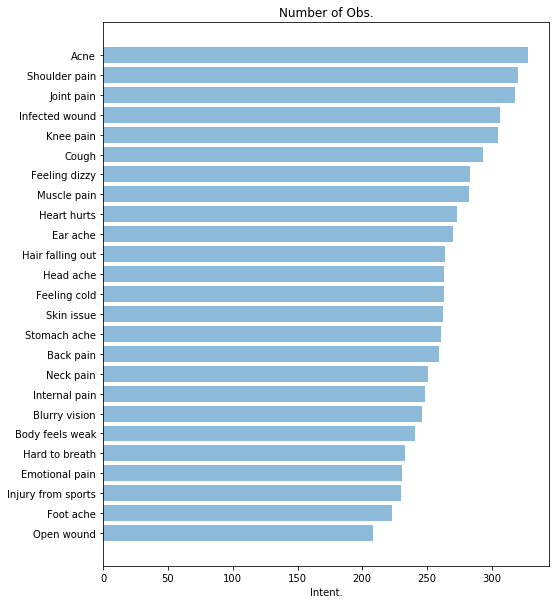

In [22]:
number_per_intent = plot_distribution(all_intents)

### Dataset length

In [11]:
len(all_intents)

6661

### Average Observations

In [30]:
## TODO
## STANDARD DEVIATION
## INCORPORATE GREETINGS !!
total_classes = len(number_per_intent)
average_observations = len(all_intents) / total_classes
average_observations

266.44

## Data Preparation

### Under Sampling

All categories above the mean will be randomly undersampled to this number.

In [46]:
def reduce_obs(avg, total):
    return total - round((total - avg)  * 0.5)

new_desired_obs = {
    class_name: reduce_obs(average_observations, total_obs) if total_obs > average_observations else None
    for (class_name, total_obs) in number_per_intent
}

In [140]:
filtered_desired_obs = { key: value for key, value in new_desired_obs.items() if value }
filtered_undesired_obs = { key: value for key, value in new_desired_obs.items() if value is None }

In [66]:
def filter_reduce_intent(data, intent, desired):
    intent_obs = [sample for sample in data if sample['intent'] == intent]
    return random.sample(intent_obs, desired)


In [136]:
reduced_intents = np.concatenate([
    filter_reduce_intent(all_intents, intent, desired_value)
    for intent, desired_value in filtered_desired_obs.items()
]).tolist()

In [160]:
lower_than_average = [sample for sample in all_intents if sample['intent'] in filtered_undesired_obs.keys()]

In [161]:
lowered_all_intents = reduced_intents + lower_than_average

,class,number of obs.
0,Open wound,208
1,Foot ache,223
2,Injury from sports,230
3,Emotional pain,231
4,Hard to breath,233
5,Body feels weak,241
6,Blurry vision,246
7,Internal pain,248
8,Neck pain,251
9,Back pain,259


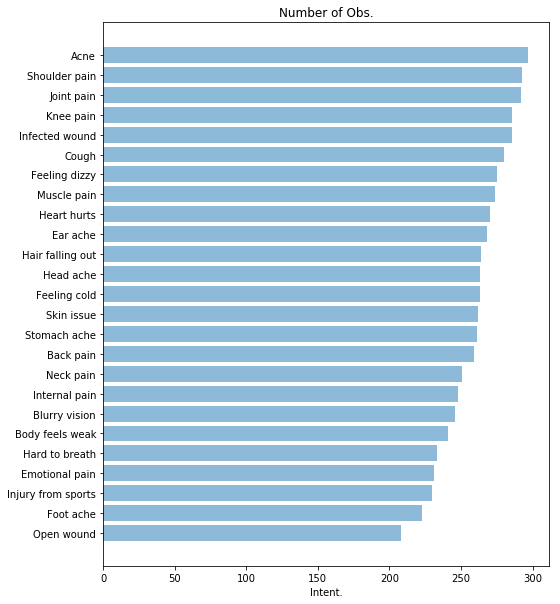

[('Open wound', 208),
 ('Foot ache', 223),
 ('Injury from sports', 230),
 ('Emotional pain', 231),
 ('Hard to breath', 233),
 ('Body feels weak', 241),
 ('Blurry vision', 246),
 ('Internal pain', 248),
 ('Neck pain', 251),
 ('Back pain', 259),
 ('Stomach ache', 261),
 ('Skin issue', 262),
 ('Feeling cold', 263),
 ('Head ache', 263),
 ('Hair falling out', 264),
 ('Ear ache', 268),
 ('Heart hurts', 270),
 ('Muscle pain', 274),
 ('Feeling dizzy', 275),
 ('Cough', 280),
 ('Infected wound', 286),
 ('Knee pain', 286),
 ('Joint pain', 292),
 ('Shoulder pain', 293),
 ('Acne', 297)]

In [164]:
plot_distribution(lowered_all_intents)

### Oversampling

In [165]:
vecs_spacy_pre_smote, labels_spacy_pre_smote = (
    spacy_sentence_vector_matrix(lowered_all_intents),
    extract_intents(lowered_all_intents) 
)

```
# (
# 	[
# 	   [0.12432, 1.2345, -1.2345 ... x 300], --> "I have a muscle pain in my left leg"
# 	   [0.65433, 1.9876, -1.2345 ... x 300], --> "I lose a lot of my hair"
# 	   [0.14554, 1.8263, -0.8765 ... x 300]  --> "I feel a pain in my back"
# 	],
# 	[
# 		"Foot ache",
# 		"Hair loss",
# 		"Back pain"
# 	]
# )
```


In [177]:
def increase_obs_amount(data, intent, avg):
    data_by_intent = [sample for sample in data if sample['intent'] == intent]
    data_length = len(data_by_intent)
    return data_length + round((avg - data_length)  * 0.5)

oversample_ratio = {
    intent: increase_obs_amount(lowered_all_intents, intent, average_observations)
    for intent in filtered_undesired_obs
}

In [179]:
smote_spacy = SMOTE(random_state=42, sampling_strategy=oversample_ratio)
vecs_spacy_smote, labels_spacy_smote = smote_spacy.fit_resample(vecs_spacy_pre_smote, labels_spacy_pre_smote)

,class,number of obs.
0,Open wound,237
1,Foot ache,245
2,Injury from sports,248
3,Emotional pain,249
4,Hard to breath,250
5,Body feels weak,254
6,Blurry vision,256
7,Internal pain,257
8,Neck pain,259
9,Back pain,263


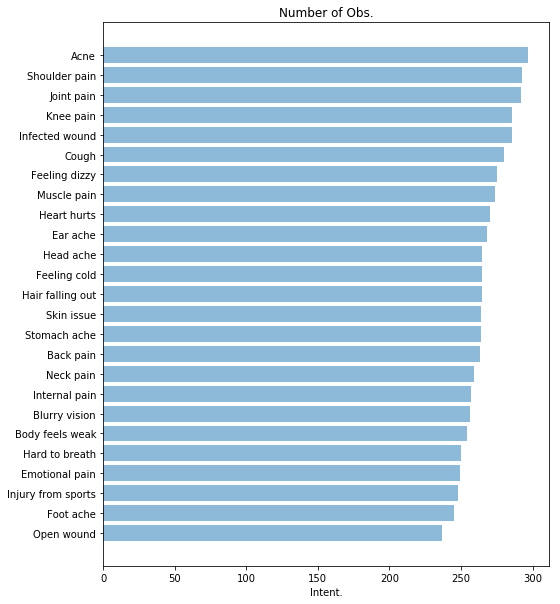

In [188]:
smote_classes_names = list(set(labels_spacy_smote))

y_pos = np.arange(len(smote_classes_names))
smote_number_per_intent = [ 
    (unique_label, len([name for name in labels_spacy_smote if name == unique_label]))
    for unique_label in smote_classes_names
]

smote_number_per_intent.sort(key = lambda tuple : tuple[1])

sorted_smote_class_names = [tuple[0] for tuple in smote_number_per_intent]
sorted_smote_number_per_intent = [tuple[1] for tuple in smote_number_per_intent]

draw_plot(sorted_smote_class_names, sorted_smote_number_per_intent)


In [187]:
smote_number_per_intent.sort(key = lambda tuple : tuple[1])

TypeError: 'int' object is not subscriptable